<a href="https://colab.research.google.com/github/imusicmash/learning-langgraph/blob/main/learning_langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## langgraph hello world

In [ ]:
# another example
# https://blog.madhukaraphatak.com/exploring-langgraph-part-1

In [1]:
!pip install -U langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.9/130.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.8 MB/s eta 0:00:00


In [15]:
from langgraph.graph import MessagesState

# use a type hint, the function expects an argument named state and this should be an instance of MessagesState class

def hello_world_agent(state:MessagesState):
    return {"messages":["hello world. i love you"]}

def hello_world_agent2(state:MessagesState):
    return {"messages":["It's raining outside"]}


In [16]:
from langgraph.graph import END, START, StateGraph

# add nodes
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("hello_world_agent",hello_world_agent)
graph_builder.add_node("hello_world_agent2",hello_world_agent2)

# add edges
graph_builder.add_edge(START,"hello_world_agent")
graph_builder.add_edge("hello_world_agent", "hello_world_agent2")
graph_builder.add_edge("hello_world_agent2",END)

In [17]:
graph = graph_builder.compile()

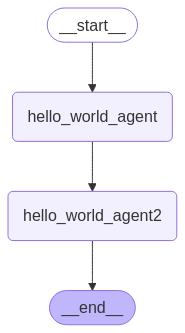

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
for event in graph.stream({"messages": ["apples"]}):
    for value in event.values():
        print(value)

{'messages': ['hello world. i love you']}
{'messages': ["It's raining outside"]}


## with conditional edge

In [ ]:
# beginner guide https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141
# While LangChain allows you to define chains of computation (Directed Acyclic Graphs or DAGs),
# LangGraph introduces the ability to add cycles, enabling more complex,
# agent-like behaviors where you can call an LLM in a loop, asking it what action to take next.


In [31]:
from typing import Dict, TypedDict, Optional

# create new class that inherits TypedDict
# Think of TypedDict as a way to create a dictionary where the keys have specific data types.
class GraphState(TypedDict):
    question: Optional[str] = None
    classification: Optional[str] = None
    response: Optional[str] = None

In [32]:
# This is a class from the langgraph library that represents a state-based graph.
# Essentially, it's a way to define a series of steps (or nodes) that are connected by edges.
# Each step potentially modifies the "state" of the graph, affecting how the workflow progresses.
# The state graph is central to LangGraph and manages
# the flow of execution through the nodes.

# next instantiate a StateGraph object, passing Graph state as the argument in constructor
# different than prior example which used MessageState as the argument.
workflow = StateGraph(GraphState)

In [40]:
# prompt: write a little function called classify that randomly returns the string "greeting" or "handle_search"

import random

def classify(question: str) -> str:
    """Randomly classifies the input question."""
    return random.choice(["greeting", "handle_search"])


In [41]:
# We define nodes for classifying the input, handling greetings, and handling search queries.

def classify_input_node(state):
    question = state.get('question', '').strip()
    classification = classify(question)  # Assume a function that classifies the input
    return {"classification": classification}

def handle_greeting_node(state):
    return {"response": "Hello! How can I help you today?"}

def handle_search_node(state):
    question = state.get('question', '').strip()
    search_result = f"Search result for '{question}'"
    return {"response": search_result}

In [42]:
# We add our nodes to the graph and define the flow using edges and conditional edges.

workflow.add_node("classify_input", classify_input_node)
workflow.add_node("handle_greeting", handle_greeting_node)
workflow.add_node("handle_search", handle_search_node)

def decide_next_node(state):
    return "handle_greeting" if state.get('classification') == "greeting" else "handle_search"



ValueError: Node `classify_input` already present.

In [43]:
# langgraph is designed to manage the state of the workflow automatically.
# When you use add_conditional_edges, you're essentially telling langgraph:

workflow.add_conditional_edges(
    "classify_input",
    decide_next_node,
    {
        "handle_greeting": "handle_greeting",
        "handle_search": "handle_search"
    }
)

ValueError: Branch with name `decide_next_node` already exists for node `classify_input`

In [44]:
# We set the entry point for our graph and define the end points.
workflow.set_entry_point("classify_input")
workflow.add_edge('handle_greeting', END)
workflow.add_edge('handle_search', END)

In [45]:
app = workflow.compile()

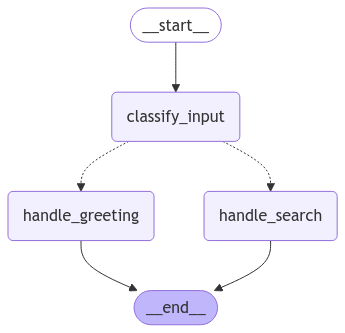

In [46]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [51]:
inputs = {"question": "Hello, how are you?"}
result = app.invoke(inputs)
print(result)

{'question': 'Hello, how are you?', 'classification': 'handle_search', 'response': "Search result for 'Hello, how are you?'"}


## With tools

In [49]:
# How to build ai agents with langraph step by step
# https://medium.com/@lorevanoudenhove/how-to-build-ai-agents-with-langgraph-a-step-by-step-guide-5d84d9c7e832

# While LangChain allows the creation of Directed Acyclic Graphs (DAGs) for linear workflows,
# LangGraph takes this a step further by enabling the addition of cycles, which are essential for
# developing complex, agent-like behaviors. These behaviors allow LLMs to continuously loop through a process,
# dynamically deciding what action to take next based on evolving conditions.

In [74]:
!pip install --upgrade langchain langchain_anthropic

from langchain_core.tools import tool

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

from langchain_anthropic import ChatAnthropic

In [ ]:
# Next, we define a tool that will handle the computation of energy savings based on the monthly
# electricity cost provided by the user.

In [62]:
@tool
def compute_savings(monthly_cost: float) -> float:
    """
    Tool to compute the potential savings when switching to solar energy based on the user's monthly electricity cost.

    Args:
        monthly_cost (float): The user's current monthly electricity cost.

    Returns:
        dict: A dictionary containing:
            - 'number_of_panels': The estimated number of solar panels required.
            - 'installation_cost': The estimated installation cost.
            - 'net_savings_10_years': The net savings over 10 years after installation costs.
    """
    def calculate_solar_savings(monthly_cost):
        # Assumptions for the calculation
        cost_per_kWh = 0.28
        cost_per_watt = 1.50
        sunlight_hours_per_day = 3.5
        panel_wattage = 350
        system_lifetime_years = 10

        # Monthly electricity consumption in kWh
        monthly_consumption_kWh = monthly_cost / cost_per_kWh

        # Required system size in kW
        daily_energy_production = monthly_consumption_kWh / 30
        system_size_kW = daily_energy_production / sunlight_hours_per_day

        # Number of panels and installation cost
        number_of_panels = system_size_kW * 1000 / panel_wattage
        installation_cost = system_size_kW * 1000 * cost_per_watt

        # Annual and net savings
        annual_savings = monthly_cost * 12
        total_savings_10_years = annual_savings * system_lifetime_years
        net_savings = total_savings_10_years - installation_cost

        return {
            "number_of_panels": round(number_of_panels),
            "installation_cost": round(installation_cost, 2),
            "net_savings_10_years": round(net_savings, 2)
        }

    # Return calculated solar savings
    return calculate_solar_savings(monthly_cost)

In [63]:
# state management and error handling

def handle_tool_error(state) -> dict:
    """
    Function to handle errors that occur during tool execution.

    Args:
        state (dict): The current state of the AI agent, which includes messages and tool call details.

    Returns:
        dict: A dictionary containing error messages for each tool that encountered an issue.
    """
    # Retrieve the error from the current state
    error = state.get("error")

    # Access the tool calls from the last message in the state's message history
    tool_calls = state["messages"][-1].tool_calls

    # Return a list of ToolMessages with error details, linked to each tool call ID
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",  # Format the error message for the user
                tool_call_id=tc["id"],  # Associate the error message with the corresponding tool call ID
            )
            for tc in tool_calls  # Iterate over each tool call to produce individual error messages
        ]
    }

def create_tool_node_with_fallback(tools: list) -> dict:
    """
    Function to create a tool node with fallback error handling.

    Args:
        tools (list): A list of tools to be included in the node.

    Returns:
        dict: A tool node that uses fallback behavior in case of errors.
    """
    # Create a ToolNode with the provided tools and attach a fallback mechanism
    # If an error occurs, it will invoke the handle_tool_error function to manage the error
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)],  # Use a lambda function to wrap the error handler
        exception_key="error"  # Specify that this fallback is for handling errors
    )

In [64]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [65]:
# a bit fancier of an instantiation of inheritance from
class Assistant:
    def __init__(self, runnable: Runnable):
        # Initialize with the runnable that defines the process for interacting with the tools
        self.runnable = runnable

    def __call__(self, state: State):
        while True:
            # Invoke the runnable with the current state (messages and context)
            result = self.runnable.invoke(state)

            # If the tool fails to return valid output, re-prompt the user to clarify or retry
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                # Add a message to request a valid response
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                # Break the loop when valid output is obtained
                break

        # Return the final state after processing the runnable
        return {"messages": result}

In [75]:
# set the LLM with langchain's llm implementation

anthropic_key = userdata.get('anthropic_zi2')

llm = ChatAnthropic(anthropic_api_key=anthropic_key, model="claude-3-5-sonnet-20241022")


In [ ]:
# The first part of the workflow involves creating a prompt template that defines how the assistant
# will communicate with the user. The prompt helps guide the AI assistant
# in determining what to ask the user, how to respond based on the input,
# and when to trigger tools like compute_savings.

# In this case, the assistant needs to ask the user for their monthly electricity
# cost to calculate solar panel savings. Here’s how we define the conversation:

In [76]:
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            '''You are a helpful customer support assistant for Solar Panels Belgium.
            You should get the following information from them:
            - monthly electricity cost
            If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

            After you are able to discern all the information, call the relevant tool.
            ''',
        ),
        ("placeholder", "{messages}"),
    ]
)

In [77]:
# Next, we define the tools that the assistant will use during the interaction,
# with the primary tool being compute_savings, which calculates potential savings based
# on the user's monthly electricity cost. After specifying the tools in the list,
# we bind them to the assistant's
# workflow using the llm.bind_tools() method.

# Define the tools the assistant will use
part_1_tools = [
    compute_savings
]

# Bind the tools to the assistant's workflow
# Note: weird.. why bind the tools to the LLM (in llamaindex u bind the tools to the agent)
# | operator is for the chain..
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

In [78]:
# construct the graph structure for the ai assistant using langgraph

builder = StateGraph(State)
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))

In [79]:
# add edges
builder.add_edge(START, "assistant")  # Start with the assistant
builder.add_conditional_edges("assistant", tools_condition)  # Move to tools after input
builder.add_edge("tools", "assistant")  # Return to assistant after tool execution

In [81]:
from langgraph.checkpoints import MemorySaver  # Import MemorySaver from langgraph.checkpoints

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

ModuleNotFoundError: No module named 'langgraph.checkpoints'

In [82]:
from langchain.callbacks.manager import CallbackManagerForChainRun  # Import from langchain
from langchain.memory import ConversationBufferMemory  # Import from LangChain

# ... (your existing code) ...

# Create and set checkpointer using ConversationBufferMemory
memory = ConversationBufferMemory()  # Create instance of ConversationBufferMemory
checkpointer = CallbackManagerForChainRun.get_noop_manager()  # Get a noop manager to ensure compatibility

# ... (your existing code) ...

graph = builder.compile(checkpointer=checkpointer, callbacks=[memory.save_context, memory.load_memory_variables])

<ipython-input-82-0397a723e34c>:7: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory()  # Create instance of ConversationBufferMemory


TypeError: StateGraph.compile() got an unexpected keyword argument 'callbacks'

In [84]:
memory = ConversationBufferMemory()  # Create instance of ConversationBufferMemory
# checkpointer = CallbackManagerForChainRun.get_noop_manager()  # Get a noop manager to ensure compatibility

# # ... (your existing code) ...

graph = builder.compile(checkpointer=[memory.save_context, memory.load_memory_variables]) # replace checkpointer and callbacks with checkpointers

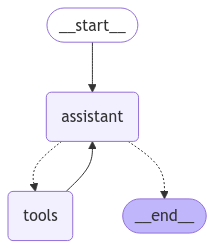

In [85]:
# draw the graph

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [86]:
# run the assistant, initiate graph and start the convo
# import shutil

import uuid

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    'hey',
    'can you calculate my energy saving',
    "my montly cost is $100, what will i save"
]

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "thread_id": thread_id,
    }
}

_printed = set()
for question in tutorial_questions:
    events = graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

AttributeError: 'list' object has no attribute 'get_next_version'